Source/inspiration: https://antonsruberts.github.io/propensity-model/

Most code taking from this, then altering to work in newer versions of packages where API broke.

This notebook involves using Compose/Featuretools to treat datasets like a database, forging relationships and automatically generating features, then PyCaret to train a model on the resulting datasets to solve a classification problem regarding "super" customers.

This was run using Python 3.8.12 with the associated packages frozen in supercustomer_propensity.txt

Note: PyCaret is very heavy so in a "Real" scenario one would likely have a seperate environment for Featuretools/Compose, and PyCaret, so you wouldn't have to dance around the dependencies.

In [1]:
import pandas as pd
import numpy as np
import datetime 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

#Label engineering
import composeml as cp

#Feature engineering
import featuretools as ft


plt.rcParams['figure.figsize'] = (20, 10)
pd.set_option('float_format', '{:f}'.format)

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
import pycaret
# check version
from pycaret.utils import version
version()

'2.3.6'

In [3]:
from pycaret.classification import *

In [4]:
plt.rcParams['figure.figsize'] = (20, 10)
pd.set_option('float_format', '{:f}'.format)

In [23]:
# Transactions
transactions = pd.read_csv('../data/customer_propensity/customer_transaction_data.csv', parse_dates=[0])
# Products
items = pd.read_csv('../data/customer_propensity/item_data.csv')
# Customers
customers = pd.read_csv('../data/customer_propensity/customer_demographics.csv')

In [24]:
print('Data is from {} and to {}'.format(transactions.date.min().date(), transactions.date.max().date()))
print('There are total {} customers'.format(transactions.customer_id.nunique()))

Data is from 2012-01-02 and to 2013-07-03
There are total 1582 customers


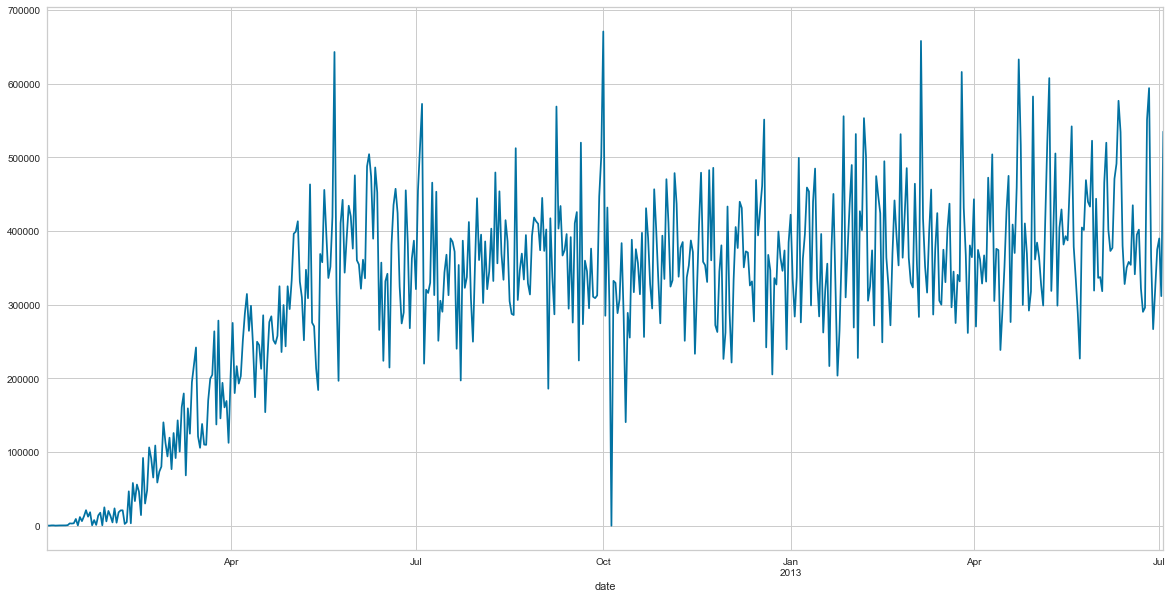

In [25]:
#Plot the total sales
transactions.groupby('date')['quantity'].sum().plot()
plt.show()

count   1582.000000
mean      90.041087
std       56.542587
min       10.000000
25%       50.000000
50%       76.000000
75%      111.000000
max      386.000000
Name: date, dtype: float64


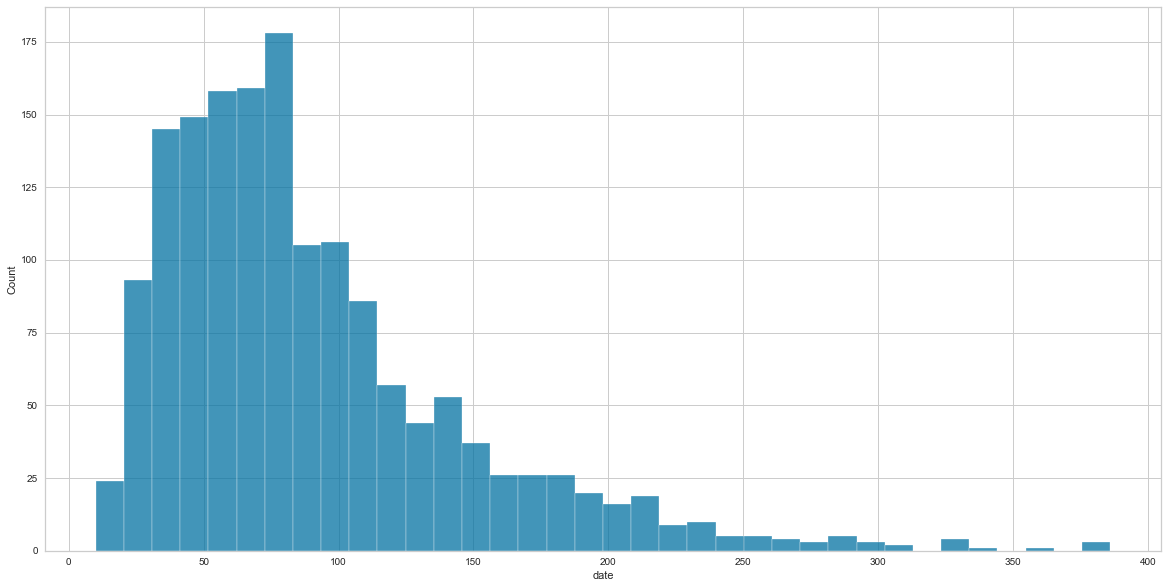

In [26]:
#On how many days do people make purchases?
print(transactions.groupby(['customer_id'])['date'].nunique().describe())
sns.histplot(transactions.groupby(['customer_id'])['date'].nunique())
plt.show()

There is total 19 unique year-months
count   1582.000000
mean      15.675727
std        2.251522
min        4.000000
25%       15.000000
50%       16.000000
75%       17.000000
max       19.000000
Name: year_month, dtype: float64


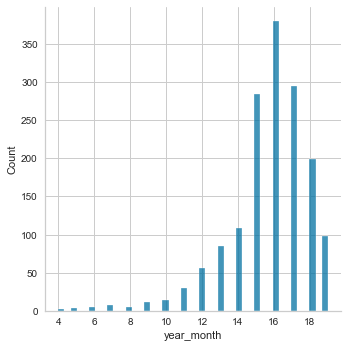

In [27]:
#In how many unique months do people make purchases?
transactions['year_month'] = pd.to_datetime(transactions['date'].apply(lambda x: x.strftime('%B-%Y')) )
print('There is total {} unique year-months'.format(transactions['year_month'].nunique()))

print(transactions.groupby(['customer_id'])['year_month'].nunique().describe())
sns.displot(transactions.groupby(['customer_id'])['year_month'].nunique())
plt.show()

In [28]:
#How many transactions do people have every month?
cust_transactions = transactions.groupby(['customer_id', 'year_month'])['quantity'].sum()
print(cust_transactions.describe())

count    24799.000000
mean      6978.999839
std      16192.200044
min          1.000000
25%         27.000000
50%         70.000000
75%       5814.000000
max     255639.000000
Name: quantity, dtype: float64


# Feature Creation

In [29]:
#group by id and date
transformed_data = pd.DataFrame(transactions.groupby(['customer_id', 'date'])[['quantity', 'selling_price']].sum()).reset_index()
transformed_data.head()

,customer_id,date,quantity,selling_price
0,1,2012-02-21,31,2603.450000
1,1,2012-03-08,13,1431.200000
2,1,2012-03-29,9,691.730000
3,1,2012-04-04,28,1913.500000
4,1,2012-04-11,17,1702.280000


In [30]:
#How many items do people purchase weekly?
weekly_purchases = transformed_data.groupby(['customer_id', pd.Grouper(key='date', freq='W-MON')])['quantity'].sum().reset_index().sort_values('date')
weekly_purchases['quantity'].describe()

count    75552.000000
mean      2290.769497
std       6036.070553
min          1.000000
25%          8.000000
50%         20.000000
75%         49.000000
max     122593.000000
Name: quantity, dtype: float64

In [31]:
transactions.sort_values("date")

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount,year_month
0,2012-01-02,1501,26830,1,35.260000,-10.690000,0.000000,2012-01-01
113,2012-01-02,464,20697,1,92.260000,-21.370000,-35.620000,2012-01-01
114,2012-01-02,464,20717,2,28.500000,-27.780000,0.000000,2012-01-01
115,2012-01-02,464,21008,1,35.260000,-17.810000,0.000000,2012-01-01
116,2012-01-02,464,22243,2,118.970000,-22.800000,0.000000,2012-01-01
...,...,...,...,...,...,...,...,...
1323113,2013-07-03,208,14759,1,89.050000,-6.770000,0.000000,2013-07-01
1323112,2013-07-03,208,13212,1,120.750000,0.000000,0.000000,2013-07-01
1323111,2013-07-03,208,11332,1,142.120000,0.000000,0.000000,2013-07-01
1323125,2013-07-03,208,30932,1,106.500000,0.000000,0.000000,2013-07-01


In [32]:
#Function to label the customers, designating those above the 75% as "super customers"
def is_super(df):
    total = df['quantity'].sum()
    if total > 49:
        return 1
    else:
        return 0

#Creating LabelMaker instance
label_maker = cp.LabelMaker(
    target_dataframe_name="customer_id", #for whom to create labels?
    time_index="date",
    labeling_function=is_super, #scoring function above
    window_size="W" #weekly window
)

In [33]:
#Creating labels
lt = label_maker.search(
    df=transactions.sort_values('date'),
    #minimum_data='2012-07-02', #date where the first label will be created
    num_examples_per_instance=-1, #its flexible
    verbose=False, #will show a progress bar
    drop_empty=False #don't drop the weeks with no purchase
)

lt.head()

,customer_id,time,is_super
0,1,2012-02-21,0
1,1,2012-02-26,0
2,1,2012-03-04,0
3,1,2012-03-11,0
4,1,2012-03-18,0


In [34]:
print('There are {} unique weeks and {} unique customers'.format(lt.time.nunique(), lt.customer_id.nunique()))
print(f'\nOn average each customer was super-customer {int(lt.loc[lt.is_super == 1, :]["customer_id"].value_counts().describe()["mean"])} times' )
print(f'\nMedian number of times each customer was super-customer is {int(lt.loc[lt.is_super == 1, :]["customer_id"].value_counts().describe()["50%"])}' )


There are 193 unique weeks and 1582 unique customers

On average each customer was super-customer 13 times

Median number of times each customer was super-customer is 9


## Features

This is similar to database modeling. Featuretools takes an "entity set", adding in dataframes similar to database tables 
where you can add relationships.

In [35]:
#Creating entity set
es = ft.EntitySet(id="customer_data")

In [36]:
# TRANSACTIONS

#Concatenate the fields to create ID 
transactions['transaction_id'] = transactions.date.astype(str) + '_' + transactions.customer_id.astype(str) + '_' + transactions.item_id.astype(str)

#remove duplicates
transactions_cleaned = transactions.drop_duplicates(subset='transaction_id')
transactions_cleaned = transactions_cleaned[['transaction_id', 'date', 'customer_id', 'item_id', 'quantity', 'selling_price',
       'other_discount', 'coupon_discount']]

In [37]:
# ITEMS

es = es.add_dataframe(dataframe_name="transactions",
                      dataframe=transactions_cleaned,
                      index="transaction_id",
                      time_index="date",
                      logical_types={"item_id": "Categorical"})

In [38]:
es = es.add_dataframe(dataframe_name="items",
                             dataframe=items,
                             index="item_id",
                             logical_types={"brand": "Categorical",
                                           "item_id": "Categorical"})

In [39]:
es = es.add_relationship(parent_dataframe_name="items", 
                         parent_column_name="item_id",
                         child_dataframe_name="transactions",
                         child_column_name="item_id")

In [40]:
# CUSTOMERS

es = es.add_dataframe(dataframe_name='customers',
                             dataframe=customers,
                             index='customer_id',
                             logical_types={"rented": "Categorical",
                                            "no_of_children": "Categorical",
                                            "income_bracket": "Categorical"})

In [41]:
es = es.add_relationship(parent_dataframe_name="customers", 
                         parent_column_name="customer_id",
                         child_dataframe_name="transactions",
                         child_column_name="customer_id")

In [42]:
# Here you can see the dataframes and relationships that were added
es

Entityset: customer_data
  DataFrames:
    transactions [Rows: 1320387, Columns: 8]
    items [Rows: 74066, Columns: 4]
    customers [Rows: 760, Columns: 7]
  Relationships:
    transactions.item_id -> items.item_id
    transactions.customer_id -> customers.customer_id

This is iterating over weekly level since we're making weekly predictions, thus the 7...14....21

This is going to create features for each week level and then concatenate them together

In [44]:
day_windows = [7, 14, 21, 28, 35, 42, 49, 56] #all the window frames
feature_dfs = [] #to populate with features
feature_encodings = []

for w in day_windows:
    print(f"For {w} day window -")
    feature_matrix, features = ft.dfs(target_dataframe_name="customers", 
                                  cutoff_time=lt, #the labels created earlier
                                  training_window=ft.Timedelta(f"{str(w)} days"), #Window populated in the for loop
                                  ignore_columns = {'customers': [c for c in customers.columns[1:]]}, #ignore demographic variables
                                  max_features = 20, #number of features to generate per window
                                  entityset=es, #schema created before
                                  verbose=True
                                 )
    
    encoded, wfeatures_encoded = ft.encode_features(feature_matrix, features) #outputs the dataframe and names of generated features
    feature_matrix.columns = [f'D{str(w)}_' + c for c in feature_matrix.columns] #renaming columns to merge 
    feature_matrix = feature_matrix[[c for c in feature_matrix.columns if 'is_super' not in c]] #excluding the label column to not get duplicated
    feature_dfs.append(encoded) #populating the list above
    feature_encodings.append(features) #saving for later use

For 7 day window -
Built 20 features
Elapsed: 01:22 | Progress: 100%|█████████████████████████████████████████████████████████████████████████████
For 14 day window -
Built 20 features
Elapsed: 01:26 | Progress: 100%|█████████████████████████████████████████████████████████████████████████████
For 21 day window -
Built 20 features
Elapsed: 01:28 | Progress: 100%|█████████████████████████████████████████████████████████████████████████████
For 28 day window -
Built 20 features
Elapsed: 01:27 | Progress: 100%|█████████████████████████████████████████████████████████████████████████████
For 35 day window -
Built 20 features
Elapsed: 01:29 | Progress: 100%|█████████████████████████████████████████████████████████████████████████████
For 42 day window -
Built 20 features
Elapsed: 01:32 | Progress: 100%|█████████████████████████████████████████████████████████████████████████████
For 49 day window -
Built 20 features
Elapsed: 01:31 | Progress: 100%|███████████████████████████████████████████

In [45]:
#Joining all features
all_features = pd.concat(feature_dfs, axis=1) 

#Adding label column
all_features['is_super'] = lt['is_super'].values

In [46]:
all_features.head()

,COUNT(transactions),MAX(transactions.coupon_discount),MAX(transactions.other_discount),MAX(transactions.quantity),MAX(transactions.selling_price),MEAN(transactions.coupon_discount),MEAN(transactions.other_discount),MEAN(transactions.quantity),MEAN(transactions.selling_price),MIN(transactions.coupon_discount),...,MODE(transactions.item_id) = 34047.0,MODE(transactions.item_id) = 9281.0,MODE(transactions.item_id) = 45502.0,MODE(transactions.item_id) = 18156.0,MODE(transactions.item_id) = 13174.0,MODE(transactions.item_id) = 6958.0,MODE(transactions.item_id) = 30851.0,MODE(transactions.item_id) = 30293.0,MODE(transactions.item_id) = 5798.0,MODE(transactions.item_id) is unknown
customer_id,,,,,,,,,,,,,,,,,,,,,
1,27,0.000000,0.000000,2.000000,256.110000,-1.319259,-19.920000,1.148148,96.424074,-35.620000,...,False,False,False,False,False,False,False,False,False,True
1,27,0.000000,0.000000,2.000000,256.110000,-1.319259,-19.920000,1.148148,96.424074,-35.620000,...,False,False,False,False,False,False,False,False,False,True
1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,True
1,10,0.000000,0.000000,2.000000,391.460000,0.000000,-30.598000,1.300000,143.120000,0.000000,...,False,False,False,False,False,False,False,False,False,True
1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,True


In [47]:
#Saving the data for training
import os
if not os.path.exists('../data/customer_propensity'):
    os.makedirs('../data/customer_propensity')

all_features.to_csv('../data/customer_propensity/generated_data.csv')

ft.save_features(feature_encodings[0], '../data/customer_propensity/features.json')

# Modeling

## Experiment 1: Simple


In [7]:
data = pd.read_csv('../data/customer_propensity/generated_data.csv')
data = data.drop('customer_id', axis=1)

In [8]:
data.is_super.value_counts()

0    89806
1    18853
Name: is_super, dtype: int64

In [10]:
clf1 = setup(data, target = 'is_super', session_id=123, log_experiment=True, experiment_name='with_pca',
             train_size=0.7,
             pca=True, 
             pca_components=0.95,
             fix_imbalance=True)

,Description,Value
0,session_id,123
1,Target,is_super
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(108659, 168)"
5,Missing Values,1
6,Numeric Features,154
7,Categorical Features,13
8,Ordinal Features,0
9,High Cardinality Features,0


In [11]:
# Comparing the models is as simple as a one-liner in pycaret

top_models = compare_models(sort='AUC', n_select=5, fold=5)


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7784,0.7136,0.5113,0.3944,0.4453,0.3097,0.3138,2.2320
lightgbm,Light Gradient Boosting Machine,0.7835,0.7134,0.4993,0.4018,0.4452,0.3127,0.3156,0.3560
ada,Ada Boost Classifier,0.7889,0.7062,0.4751,0.4086,0.4393,0.3102,0.3116,0.6920
lda,Linear Discriminant Analysis,0.8119,0.6741,0.4190,0.4560,0.4367,0.3240,0.3245,0.1000
lr,Logistic Regression,0.8093,0.6738,0.4283,0.4496,0.4387,0.3239,0.3240,1.3280
rf,Random Forest Classifier,0.8034,0.6732,0.3969,0.4298,0.4126,0.2948,0.2952,1.0560
et,Extra Trees Classifier,0.8083,0.6645,0.3731,0.4399,0.4037,0.2904,0.2918,0.6780
knn,K Neighbors Classifier,0.7689,0.6602,0.4269,0.3612,0.3913,0.2498,0.2512,4.5160
qda,Quadratic Discriminant Analysis,0.8102,0.6549,0.4035,0.4494,0.4252,0.3119,0.3126,0.0900
nb,Naive Bayes,0.8066,0.6519,0.4003,0.4388,0.4186,0.3029,0.3034,0.9160


In [12]:
preds = predict_model(top_models[0])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.7750,0.7061,0.4996,0.3829,0.4335,0.2961,0.3002


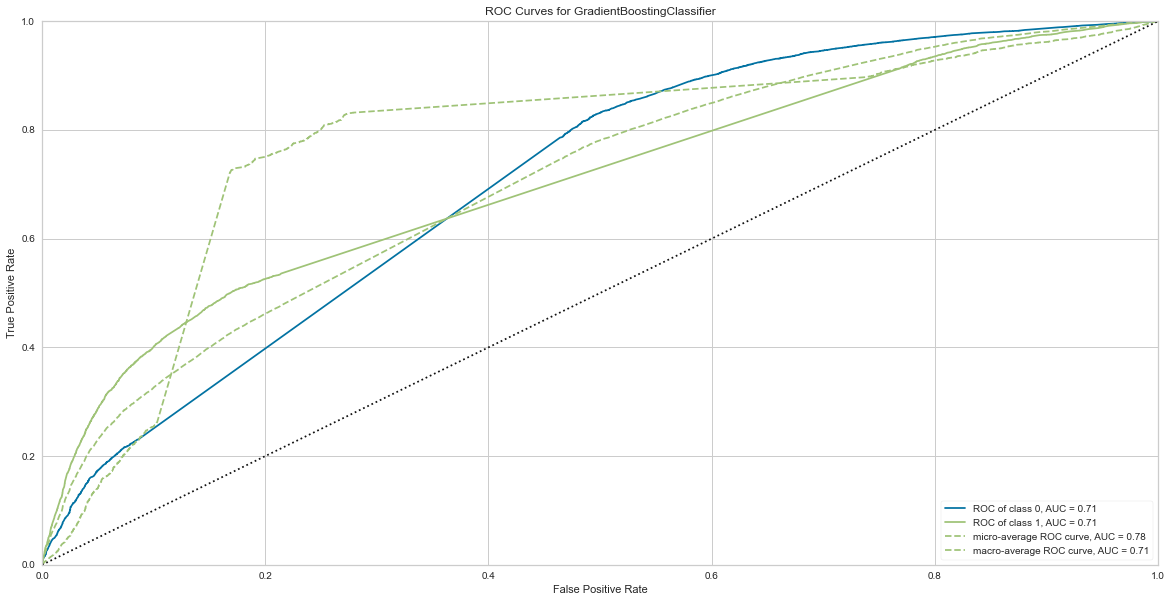

In [13]:
plot_model(top_models[0])

## Experiment 2: Advanced

In [5]:
data2 = pd.read_csv('../data/customer_propensity/generated_data.csv')
customers = pd.read_csv('../data/customer_propensity/customer_demographics.csv')

In [6]:
data_with_demo = data2.merge(customers, on='customer_id', how='left')
data_with_demo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108659 entries, 0 to 108658
Columns: 175 entries, customer_id to income_bracket
dtypes: float64(154), int64(17), object(4)
memory usage: 145.9+ MB


In [7]:
clf2 = setup(data_with_demo, target = 'is_super', session_id=123, log_experiment=True, experiment_name='with_demo_pca',
             train_size=0.7, 
             normalize = True, 
             transformation = True, 
             ignore_low_variance = True,
             remove_multicollinearity = True, 
             multicollinearity_threshold = 0.95,
             categorical_features = ['marital_status', 'rented', 'family_size', 'no_of_children', 'age_range', 'income_bracket'], 
             pca=True, pca_components=0.95, 
             fix_imbalance=True)

,Description,Value
0,session_id,123
1,Target,is_super
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(108659, 175)"
5,Missing Values,1
6,Numeric Features,155
7,Categorical Features,19
8,Ordinal Features,0
9,High Cardinality Features,0


In [8]:
top_models2 = compare_models(sort='AUC', n_select=5, fold=10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7859,0.8016,0.6010,0.4196,0.4941,0.3638,0.3733,4.4860
et,Extra Trees Classifier,0.7925,0.8001,0.5845,0.4294,0.4950,0.3682,0.3752,2.8500
lightgbm,Light Gradient Boosting Machine,0.7933,0.7546,0.5419,0.4262,0.4771,0.3506,0.3545,0.7720
knn,K Neighbors Classifier,0.7021,0.7537,0.6987,0.3312,0.4494,0.2792,0.3158,2.6750
gbc,Gradient Boosting Classifier,0.7887,0.7332,0.4918,0.4105,0.4474,0.3181,0.3201,12.1380
lr,Logistic Regression,0.7916,0.7152,0.4922,0.4164,0.4511,0.3237,0.3254,1.6020
lda,Linear Discriminant Analysis,0.7953,0.7151,0.4863,0.4232,0.4526,0.3274,0.3286,0.5370
ada,Ada Boost Classifier,0.7772,0.7081,0.4804,0.3871,0.4287,0.2923,0.2949,2.5630
qda,Quadratic Discriminant Analysis,0.7727,0.6923,0.4830,0.3796,0.4251,0.2859,0.2892,0.4100
dt,Decision Tree Classifier,0.7379,0.6600,0.5622,0.3448,0.4274,0.2699,0.2835,1.1260


In [9]:
#Tuning single model
tuned_extra = tune_model(top_models2[0])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8259,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.8261,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.8261,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.8261,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.8261,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.8261,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.8261,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.8259,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.8259,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
9,0.8259,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000


In [10]:
#Tuning all 5 best models
tuned_best = [tune_model(m) for m in top_models2]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7919,0.7694,0.5831,0.4282,0.4938,0.3666,0.3736
1,0.7935,0.7732,0.5760,0.4300,0.4924,0.3662,0.3723
2,0.7944,0.7517,0.5540,0.4294,0.4838,0.3580,0.3625
3,0.7963,0.7500,0.5540,0.4332,0.4862,0.3616,0.3659
4,0.7911,0.7743,0.5843,0.4266,0.4931,0.3656,0.3727
5,0.7950,0.7647,0.5926,0.4346,0.5014,0.3763,0.3834
6,0.7874,0.7661,0.5767,0.4192,0.4855,0.3557,0.3629
7,0.7996,0.7711,0.5740,0.4419,0.4993,0.3767,0.3818
8,0.7906,0.7560,0.5642,0.4237,0.4840,0.3559,0.3616
9,0.7984,0.7682,0.5710,0.4393,0.4966,0.3732,0.3782


## Ensembling

In [11]:
blended = blend_models(estimator_list = tuned_best[:4], method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7419,0.7855,0.6609,0.3663,0.4713,0.3187,0.3430
1,0.7583,0.7834,0.6568,0.3857,0.4860,0.3417,0.3624
2,0.7528,0.7773,0.6538,0.3782,0.4792,0.3320,0.3534
3,0.7435,0.7764,0.6342,0.3638,0.4624,0.3098,0.3304
4,0.7556,0.7854,0.6576,0.3822,0.4835,0.3378,0.3591
5,0.7501,0.7774,0.6788,0.3783,0.4858,0.3379,0.3631
6,0.7536,0.7768,0.6523,0.3790,0.4794,0.3326,0.3536
7,0.7615,0.7869,0.6684,0.3916,0.4939,0.3515,0.3730
8,0.7498,0.7750,0.6390,0.3725,0.4707,0.3214,0.3415
9,0.7594,0.7833,0.6450,0.3857,0.4828,0.3387,0.3577


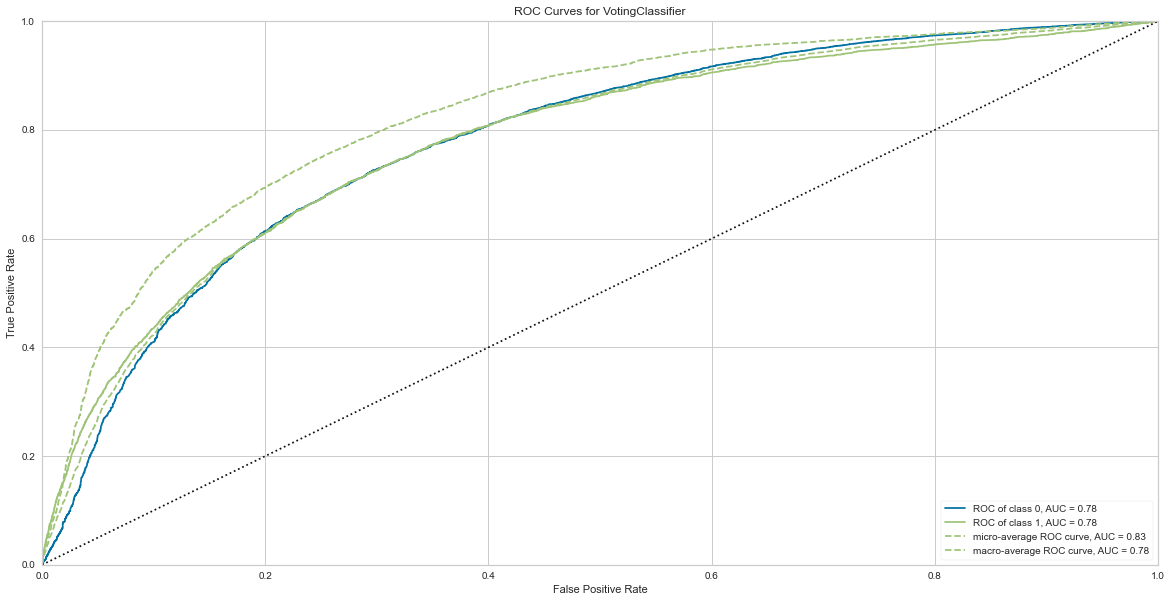

In [12]:
plot_model(blended)

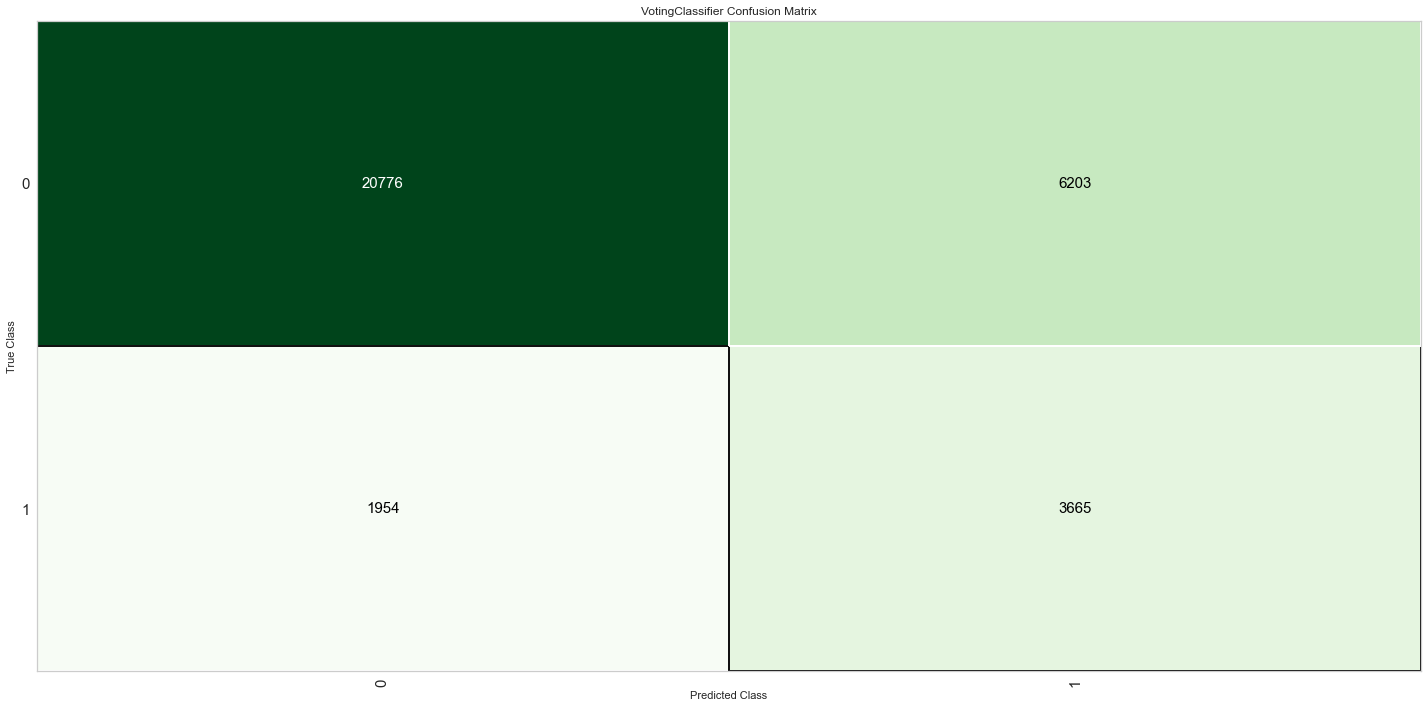

In [13]:
plot_model(blended, plot='confusion_matrix')

In [18]:
#Hold out predictions
holdout_predict = predict_model(blended)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.7498,0.7798,0.6523,0.3714,0.4733,0.3250,0.3472


In [19]:
print(holdout_predict.shape)
holdout_predict.head()

(32598, 41)


,Component_1,Component_2,Component_3,Component_4,Component_5,Component_6,Component_7,Component_8,Component_9,Component_10,...,Component_32,Component_33,Component_34,Component_35,Component_36,Component_37,Component_38,is_super,Label,Score
0,-2.787000,1.443370,-0.526228,-0.330851,-0.337315,-0.463943,-0.294595,0.058014,0.035324,0.166961,...,-0.006302,-0.021531,0.000541,0.015121,0.009628,-0.020329,-0.004014,0,1,0.578700
1,-4.272372,-1.324763,-2.499332,-1.168315,1.197943,0.005156,-1.418427,-0.454023,1.025080,-2.117510,...,0.164239,-0.050453,-0.080986,-0.280520,0.622468,0.378352,-0.306687,0,1,0.591400
2,-2.753991,1.448785,-0.520953,-0.348266,-0.344464,-0.460873,-0.299506,0.094761,0.098139,0.138901,...,0.004395,-0.019650,-0.018154,0.005233,0.004910,-0.013945,0.019782,0,0,0.625000
3,-3.783952,1.305771,-1.696568,2.159882,2.348987,3.404694,1.332098,1.103396,0.470136,-0.695966,...,-1.040054,0.517044,-0.774101,0.640601,-0.099104,-0.357294,0.994201,0,1,0.657900
4,-2.758410,1.448060,-0.521659,-0.345934,-0.343507,-0.461284,-0.298848,0.089842,0.089730,0.142658,...,0.002963,-0.019901,-0.015651,0.006557,0.005542,-0.014800,0.016596,0,1,0.608700


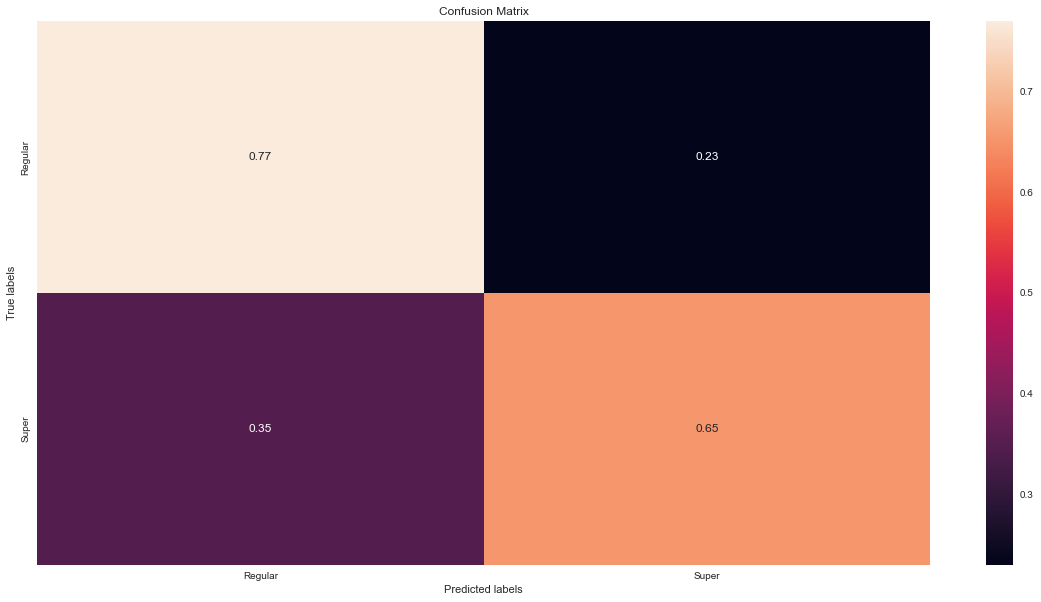

In [20]:
labels = [0,1]
cm = confusion_matrix(holdout_predict['is_super'], holdout_predict['Label'], labels, normalize='true')
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.2', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Regular', 'Super']); ax.yaxis.set_ticklabels(['Regular', 'Super']);

## Saving

In [21]:
# Retrains on all data

final_model = finalize_model(blended)

In [22]:
# Saves

save_model(final_model,'Final Blend Model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['marital_status',
                                                             'rented',
                                                             'family_size',
                                                             'no_of_children',
                                                             'age_range',
                                                             'income_bracket'],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='is_super',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strat...
                                                               ran